<a href="https://colab.research.google.com/github/fares-mldev/uns-ml2021/blob/main/tp3/ML_TP3_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML TP3 - K-Nearest Neighbours

In [1]:
#@title Imports

# numpy
import numpy as np

# matplotlib
from matplotlib import pyplot as plt

# pandas
import pandas as pd

# sklearn
# Preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
# Classifiers
from sklearn import neighbors 
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

# Seaborn
import seaborn as sns

##Ejercicio 3.1

Dado un dataset mezcla de dos grupos aleatorios bidimensionales
(cada uno con 100 datos, su centroide y covariancia).
Tip: reutilizar el código de la NB que vimos para outliers.

**Se pide:** Encontrar un clasificador por K-NN y evaluar exactitud,
precisión, f-measure. Tomar inicialmente un dataset de
entrenamiento de N=100 (50+50), k=10, y validar con el resto
del dataset. Hacer algunos experimentos con otros N y k, y
también cambiando centroide y covariancia de las clases.

In [2]:
#@title Código: Generación de datos

def gen_class(mean: np.array ,cov: np.array, size = 100, label = 0 ) -> pd.DataFrame :
  '''
  Creates a multivariate normal distributed of specified mean, covariance, sample size,
  '''

  num_features = len(mean)

  # Data
  X = np.random.multivariate_normal(mean = mean, cov = cov, size = size)

  # Labels
  y = np.array([label for i in range(X.shape[0])]).reshape(-1,1)

  # Dataframe column names
  columns = [f'feature{i:d}' for i in range(num_features)]
  columns.append('label')

  # Build dataframe
  df = pd.DataFrame(np.hstack((X,y)),columns=columns)

  return df

def rotate_cov_2d(S, angle):
  '''
  Applies a rotation to the covariance matrix
  ''' 
  # Rotation matrix
  theta = angle*np.pi/180.0
  c, s = np.cos(theta), np.sin(theta)
  R = np.array([[c, -s], [s, c]])

  # Return R*S*R'
  return R @ S @ R.T

def df_merge_shuffle(dfs: list, shuffle=True) -> pd.DataFrame:
  '''
  Given a list of datasets, merge, shuffle and reindex them
  '''
  df_out = None

  for idx, df in enumerate(dfs):
    if idx == 0:
      df_out = df
    else:
      df_out = pd.concat([df_out, df], axis=0)
  
  if shuffle:
    df_out = df_out.sample(frac=1).reset_index(drop=True)
  return df_out 

def gen_data(N = 100, dist = 1, varA = 1, rA = 0, varB = 1, rB = 0, random_seed = False):
  '''
  Create two classes 
  '''

  if not random_seed:
    # Init random seed
    np.random.seed(1)

  # Mean and covariance of class A
  meanA = [np.sqrt(dist),np.sqrt(dist)]
  covA = np.array([[varA, 0],[0, 1]])
  covA = rotate_cov_2d(covA,rA)

  # Mean and covariance of class B
  meanB = [-np.sqrt(dist),-np.sqrt(dist)]
  covB = np.array([[varB, 0],[0, 1]])
  covB = rotate_cov_2d(covB,rB)

  # Create class data
  dfA = gen_class(meanA,covA,np.int(N/2),1)
  dfB = gen_class(meanB,covB,np.int(N/2),0)

  # Merge data
  df = df_merge_shuffle([dfA, dfB])

  # Return dataset
  return df

def plot_data_2d(df: pd.DataFrame, x, y, c, ax=None):
  
  # If ax is None, het handle
  if ax is None:
    ax=plt.gca()
  
  # Plot dataset
  df.plot.scatter(x=x,y=y,c=c,colormap='viridis',ax=ax)
  ax.axis('equal')


Se realizan funciones para la generación de datos:

`gen_class`: Genera un dataset con distribución normal multivariada tomando como datos el vector de medias, covarianza, tamaño del dataset y la etiqueta

`rotate_cov_2d`: Es una función auxiliar para aplicar una rotación 2D a la matriz de covarianza. Esto se utiliza para las pruebas de variacion de la  covarianza. Toma como parámetros la matriz de covarianza y un angulo en grados.

`df_merge_shuffle`: Toma una lista de dataframes generados por gen_class y los commbina en un solo, en forma aleatoria.

`gen_data`: Genera el dataset pedido en el ejericio, tomando como parámetro para cada distribución un coeficiente de relación de varianzas `varX` (representa la relacion entre las varianzas de los feaures) y un ángulo de rotación `rX` para cada clase.

`plot_data_2d`: Grafica el dataset

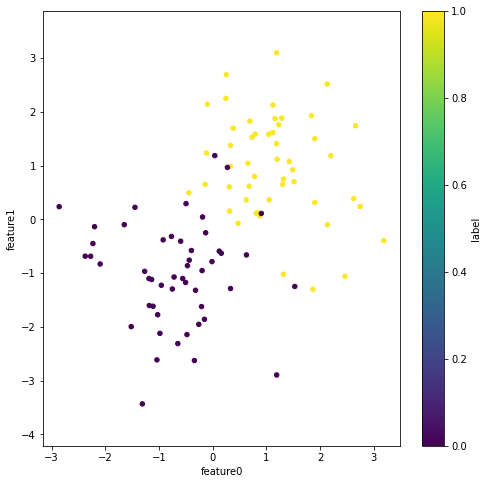

In [3]:
#@title Generación de datos { run: "auto" }

# Generate data
df = gen_data()
N = len(df)

# Plot data
fig=plt.gcf()
fig.set_size_inches(8,8)
plot_data_2d(df,'feature0','feature1','label')




In [4]:
#@title Preparación de datos: Separar en train-val { run: "auto" }
#@markdown Tamaño test set (0 a 0.5): 
val_size = 0.2 #@param {type:"slider", min:0, max:0.5, step:0.1}

def split_data(df, val_size=0.2):
  '''
  Separate dataframe in X and y, train and val
  '''  
  X = np.array(df.drop(['label'], axis=1)) 
  y = np.array(df['label'])
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size)
  
  return X_train, X_val, y_train, y_val

def prepare_data(df):
  '''
  Separate dataframe in features X and labels y
  '''  
  X = np.array(df.drop(['label'], axis=1)) 
  y = np.array(df['label'])

  return X, y

X_train, X_val, y_train, y_val = split_data(df, val_size=val_size)

La función `split_data` toma un dataframe y lo divide en features/labels (X,y) a la vex que genera un par para entrenamiento y otro para validación en función del parámetro `val_size`

La función `prepare_data` sólo separa el dataset en X,y (Usada más adelante para cross-validation)

Mediante la función fit_knn se crea y entrena un clasificador KNN (K-Nearest Neighbours) con un parámetro k. 
Se utiliza la clase `KNeighborsClassifier` de scikit learn.

In [5]:
#@title Entrenar KNN { run: "auto" }
#@markdown Número de vecinos mas cercanos: 
k = 10 #@param {type:"slider", min:5, max:15, step:5}

def fit_knn(X_train, y_train, k=15):
  '''
  Returns a trained knn data with parameter k
  '''
  clf = neighbors.KNeighborsClassifier(k, weights='uniform')
  clf.fit(X_train, y_train)

  return clf
  
clf = fit_knn(X_train, y_train, k)

Mediante la función `calc_metrics` se evalúan cuatro métricas: `accuracy`, `f1_score`, `precision` y `recall`. Se agrupan en un diccionario.

Por otro lado eval_metrics calcula las metricas tanto para el dataset de entrenamiento como para el de validación.

In [6]:
#@title Evaluar métricas{ run: "auto" }

def calc_metrics(y_true, y_pred) -> dict:
  '''
  Evaluate metrics and return them in a dictionary
  '''
  metrics = {}
  metrics['accuracy']=accuracy_score(y_true,y_pred)
  metrics['f1_score']=f1_score(y_true,y_pred)
  metrics['precision']=precision_score(y_true,y_pred)
  metrics['recall']=recall_score(y_true,y_pred)

  return metrics

def eval_metrics(clf, X_train, y_train, X_val, y_val ) -> dict:
  
  # Trining metrics
  y_pred = clf.predict(X_train)
  train_metrics = calc_metrics(y_train,y_pred)
    
  # Convert to dataset
  df_metrics_train = pd.DataFrame.from_dict([train_metrics], orient='columns')
  df_metrics_train['data'] = 'train'

  # Validation metrics
  y_pred = clf.predict(X_val)
  val_metrics = calc_metrics(y_val,y_pred)
  
  # Convert to dataset
  df_metrics_val = pd.DataFrame.from_dict([val_metrics], orient='columns')
  df_metrics_val['data'] = 'val'

  # Merge data
  df_metrics = df_merge_shuffle([df_metrics_train, df_metrics_val])

  return df_metrics

metrics = eval_metrics(clf, X_train, y_train, X_val, y_val)

metrics

,accuracy,f1_score,precision,recall,data
0,0.9375,0.936709,0.948718,0.925,train
1,0.9500,0.952381,0.909091,1.000,val


Se implementan algunas funciones auxiliares para visualizar el resultado:

`plot_clf_region`: Grafica en 2D la zona de clasificación

`plot_clf_data`: Grafica en 2D los datos de entrenamiento

`plot_results`: Combina las funciones anteriores para roducir un gráfico combinado, incluyendo los parámetros del modelo y las métricas en la descripción


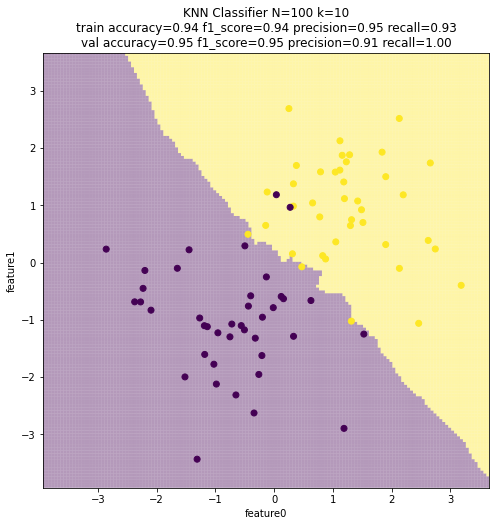

In [7]:
#@title Graficar resultados{ run: "auto" }

def plot_clf_region(clf, X, y, ax = None):

  # If ax is not passed, get handle
  if ax is None:
    ax = plt.gca()

  # step size in the mesh
  h = .05

  # Create mesh [x_min, m_max]x[y_min, y_max].
  x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
  y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
  a_min= min(x_min,y_min)
  a_max= max(x_max,y_max)

  xx, yy = np.meshgrid(np.arange(a_min, a_max, h), np.arange(a_min, a_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  ax.set_xlim(xx.min(), xx.max())
  ax.set_xlim(yy.min(), yy.max())

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  ax.pcolor(xx, yy, Z, alpha = 0.4, cmap='viridis',edgecolors=None)


def plot_clf_data(clf, X, y, ax = None):

  # If ax is not passed, get handle
  if ax is None:
    ax = plt.gca()

  # Plot also data points
  ax.scatter(X[:,0], X[:,1],c=y,cmap = 'viridis' )

def plot_clf(clf, X_train, y_train, metrics,ax=None):
  
  # If ax is None, het handle
  if ax is None:
    ax=plt.gca()

  # Build title
  title =  'KNN Classifier'
  title +=f' N={N:d} k={k:d}'

  for data in metrics.data.unique():

    title +=f'\n{data:s}'

    #filter data
    m = metrics[metrics['data']==data]

    # Iterate over columns
    for name in m:
      if name != 'data':
        value = np.float(m[name])
        title +=f' {name:s}={value:.2f}'

  # Set labels
  ax.set_xlabel('feature0')
  ax.set_ylabel('feature1')
  ax.set_title(title)

  # Plot decision region
  plot_clf_region(clf, X_train, y_train, ax=ax)

  # Plot training data
  plot_clf_data(clf, X_train, y_train, ax=ax)

fig = plt.gcf()
fig.set_size_inches(8,8)
plot_clf(clf, X_train, y_train, metrics)

A continuación se realiza un análisis de variación de N y k. 

Se observa que cuanto más pequeño sea `k` respecto de `N`, el umbral de decisión se vuelve más irregular, produciéndose "islas" en la región de decisión. Esto es un posible indicador de *overfitting* (k=1, N=100). 



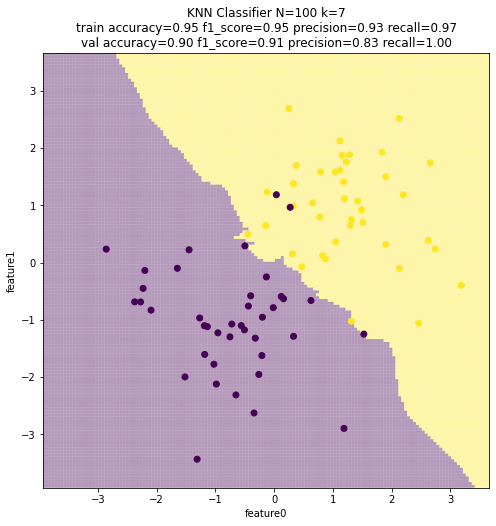

In [8]:
#@title Análisis de variación a N y k { run: "auto" }

#Número de muestras 
N = 100 #@param {type:"slider", min:10, max:100, step:10}

#@title Entrenar KNN { run: "auto" }
#@markdown Número de vecinos mas cercanos: 
k = 7 #@param {type:"slider", min:1, max:7, step:2}

# Generate data
df = gen_data(N=N)

# Split data 
X_train, X_val, y_train, y_val = split_data(df)

# Fit model
clf = fit_knn(X_train, y_train, k)

# Calculate metrics
metrics = eval_metrics(clf, X_train, y_train , X_val, y_val)

# Plot results
fig = plt.gcf()
fig.set_size_inches(8,8)
plot_clf(clf, X_train, y_train, metrics)

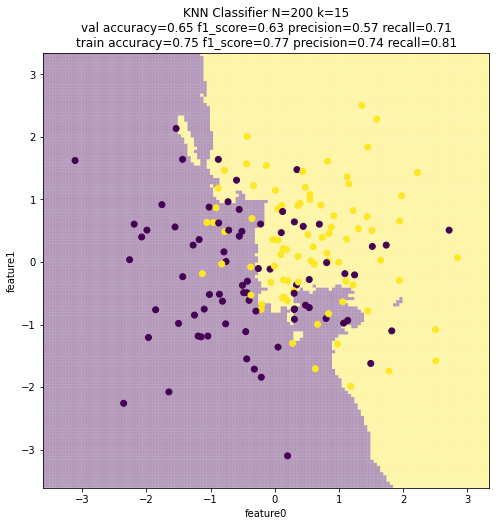

In [9]:
#@title Análisis de variación de distancia entre centroides { run: "auto" }

#@markdown Distancia entre centroides: 
dist = 0.1 #@param {type:"slider", min:0, max:2, step:0.1}

# Generate data
df = gen_data(N=200,dist=dist)
N = len(df)

# Split data 
X_train, X_val, y_train, y_val = split_data(df)

# Fit model
k = 15 
clf = fit_knn(X_train, y_train, k)

# Calculate metrics
metrics = eval_metrics(clf, X_train, y_train , X_val, y_val)

# Plot results
fig = plt.gcf()
fig.set_size_inches(8,8)
plot_clf(clf, X_train, y_train, metrics)

Al disminuir la distancia entre los centroides aumenta el error sistemático que puede cometer el clasificador. Las métricas tanto de entrenamiento como de validación disminuyen. La superficie de decisión se vuelve irregular y aumenta la varianza del clasificador.

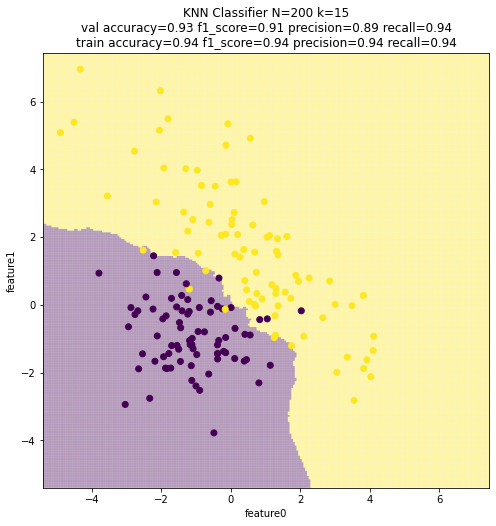

In [10]:
#@title Análisis de variación de covarianzas { run: "auto" }

#@markdown Clase A: 
varA = 10 #@param {type:"slider", min:1, max:10, step:1}
rA = -50 #@param {type:"slider", min:-90, max:90, step:10}

# Generate data
df = gen_data(N=200,varA=varA,rA=rA)
N = len(df)

# Split data 
X_train, X_val, y_train, y_val = split_data(df)

# Fit model
k = 15 
clf = fit_knn(X_train, y_train, k)

# Calculate metrics
metrics = eval_metrics(clf, X_train, y_train , X_val, y_val)

# Plot results
fig = plt.gcf()
fig.set_size_inches(8,8)
plot_clf(clf, X_train, y_train, metrics)

Al alterar las propiedades de las covarianzas de las clases (forma y rotación) la superficie de decisión cambia de la forma lineal a funciones cónicas (ej: `varA = 10`, `rA =-50`)

##Ejercicio 3.2


Utilizando el dataset anterior, implementar validación por cross-validation y búsqueda de hiperparámetros mediante Grid Search

###K-fold cross validation

Se realiza una validación cruzada k-fold con distintos tamaños de dataset y distintos parámetros k (numero de splits/folds). Se evalúan varias métricas (accuracy, f1-score, precision y recall). Dado que para cada split del dataset se genera un juego de métricas, los resultados se muestran en un boxplot, donde se aprecia la dispersión de las métricas (entre percentiles 50 y 75), así como media, valores máximos y mínimos.


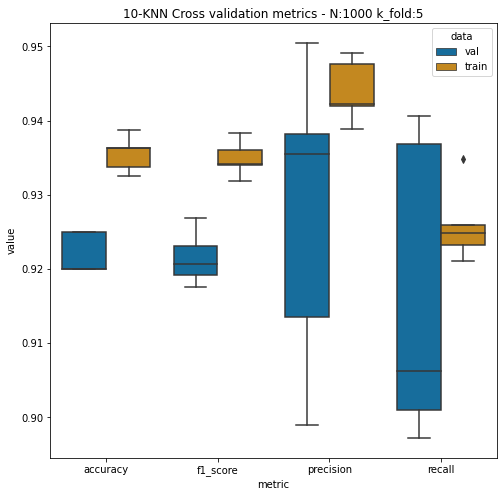

In [11]:
#@title Metricas { run: "auto" }

N = 1000 #@param {type:"slider", min:100, max:2000, step:100}
k_fold = 5 #@param {type:"slider", min:2, max:20, step:1}
knn = 10

def eval_kfold(clf, X, y, k):

  # Create KFold splitter
  kf = KFold(n_splits=k,shuffle=True)

  # Init dictionaries to store results
  metrics=[]

  # Iterate over splits
  for split, indexes in enumerate(kf.split(X)):

    # Unpack indexes
    train_index, val_index = indexes 
    
    # Split dataset
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit model
    clf.fit(X_train, y_train)

    # Calculate metrics
    df_m = eval_metrics(clf, X_train, y_train , X_val, y_val)
    df_m['split']=split
    metrics.append(df_m)

  return  df_merge_shuffle(metrics,shuffle=False)

def plot_metrics(df_metrics,ax = None):
  '''
  Plots a dataframe of metrics
  '''  
  if ax is None: 
    ax = plt.gca()

  sns.boxplot(x=df_metrics.metric, y=df_metrics.value, hue=df_metrics.data,palette="colorblind")

# Generate data
df = gen_data(N=N,dist=1)

# Get X and y
X,y = prepare_data(df)

# Create classifier
clf = neighbors.KNeighborsClassifier(knn, weights='uniform')

# Evaluate metrics
metrics = eval_kfold(clf,X, y, k_fold)

# Convert from wide to long format
metrics_long = metrics.melt(id_vars=["data", "split"], 
        var_name="metric", 
        value_name="value")

# Plot result
fig = plt.gcf()
fig.set_size_inches(8,8)
ax = plt.gca()
ax.set_title(f'{knn:d}-KNN Cross validation metrics - N:{N:d} k_fold:{k_fold:d}')
plot_metrics(metrics_long)



Se observa que a medida que aumenta el valor `k_fold` aumenta la varianza de las metricas de test, mientras que disminuyen las de train. Esto se debe a que las metricas de test se calculan sobre splits mas pequeños, mientras que las de train sobre splits mas grandes.

A pesar de la dependencia de las varianzas de las metricas respecto a `k_fold`, el valor medio no parece ser afectado de la misma forma.

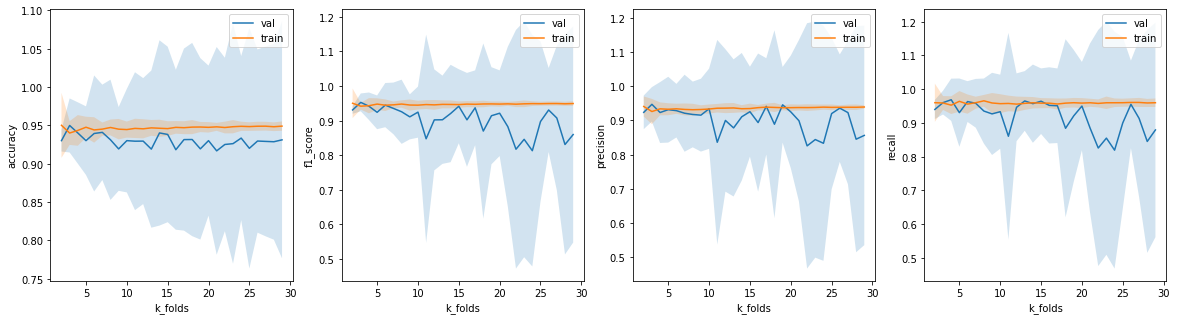

In [12]:
#@title Dependencia con numero de splits (N=100) { run: "auto" }

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

N = 100

def plot_stat_cv(param,df_results):
  '''
  Plots cross validation statistics (mean and std) against parameter
  '''
  # Metrics
  params = df_results[param].unique()
  metrics = df_results['metric'].unique()
  datas = df_results['data'].unique()
  
  fig, axes = plt.subplots(1,len(metrics))
  fig.set_size_inches(20,5)

  for idx, metric in enumerate(metrics):

    for data in reversed(datas):

      # Get means and std for metric
      means = df_results[(df_results['data']==data) & (df_results['metric']==metric)].value['mean']
      stds = df_results[(df_results['data']==data) & (df_results['metric']==metric)].value['std']
      stds = np.array(stds)

      # Plot values
      axes[idx].plot(params,means, label= data)
      axes[idx].fill_between(params, np.array(means) + stds, np.array(means) - stds, alpha=0.2)

    axes[idx].set_xlabel(param)
    axes[idx].set_ylabel(metric)
  
    # Add legends    
    axes[idx].legend()


# Generate data
df = gen_data(N=N,dist=1)

# Get X and y
X,y = prepare_data(df)

# Create classifier
clf = neighbors.KNeighborsClassifier(knn, weights='uniform')

k_folds= range(2,30)

metrics = []

# Loop over k_folds values
for k_fold in k_folds:
  # Evaluate metrics
  metric = eval_kfold(clf,X, y, k_fold)
  
  # Add k_folds column
  metric['k_folds'] = k_fold
  
  # Convert from wide to long format
  metric_long = metric.melt(id_vars=["data", "split","k_folds"], 
        var_name="metric", 
        value_name="value")

  # Append to list
  metrics.append(metric_long)

# Merge metrics in single dataframe
df_metrics = df_merge_shuffle(metrics,shuffle=False)

# Aggregate metric results for each fold
grp_results=df_metrics.groupby(by=['k_folds', 'data','metric' ]).agg({'value': ['mean', 'std']})

# Ungroup indexes
df_results=pd.DataFrame(grp_results.reset_index())

plot_stat_cv('k_folds',df_results)

Por otro lado, para un valor de `k_fold` fijo, cuando el tamaño del dataset `N` disminuye la varianza de las métricas comienza a aumentar. La causa es la misma que en el caso anterior: se disminuye el tamaño de los splits sobre los que se calculan las estadisticas produciendose overfitting. 

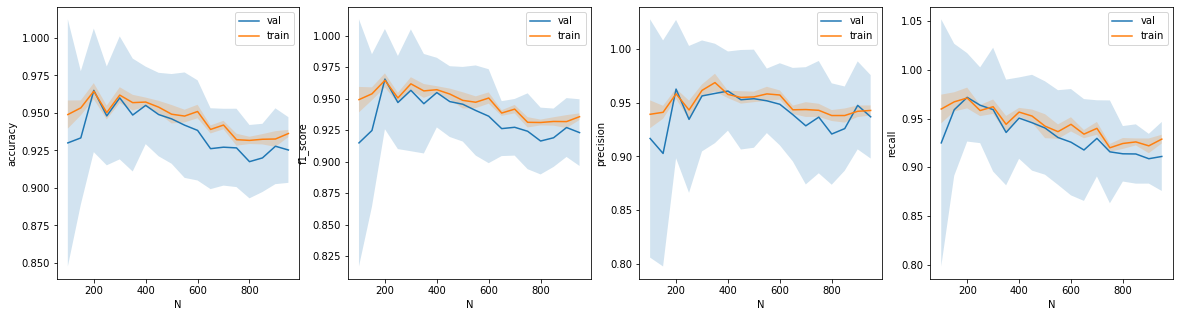

In [13]:
#@title Dependencia con numero de muestras (k-fold = 10) { run: "auto" }

k_fold = 10

means = {}
stds = {}

Ns = range(100,1000,50)

metrics = []

# Loop over N values
for N in Ns:

  # Generate data
  df = gen_data(N=N,dist=1)

  # Get X and y
  X,y = prepare_data(df)

  # Evaluate metrics
  metric = eval_kfold(clf,X, y, k_fold)
  
  # Add k_folds column
  metric['N'] = N
  
  # Convert from wide to long format
  metric_long = metric.melt(id_vars=["data", "split","N"], 
        var_name="metric", 
        value_name="value")

  # Append to list
  metrics.append(metric_long)

# Merge metrics in single dataframe
df_metrics = df_merge_shuffle(metrics,shuffle=False)

# Aggregate metric results for each fold
grp_results=df_metrics.groupby(by=['N', 'data','metric' ]).agg({'value': ['mean', 'std']})

# Ungroup indexes
df_results=pd.DataFrame(grp_results.reset_index())

plot_stat_cv('N',df_results)


###Grid Search optimization

In [14]:
#@title Optimizar KNN { run: "auto" }

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

# Model Pipeline
knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])

# Tunable parameters
params = [{'knn__n_neighbors': [1, 5, 10, 15, 20, 25, 100, 399],
           'knn__weights': ['uniform', 'distance'],
          }]

# Metrics
scoring = ['accuracy','f1']

# Grid search
gs = GridSearchCV(knn_pipe,
                   param_grid=params,
                   scoring=scoring,
                   refit='f1',
                   cv=5,
                   return_train_score=True)

# Generate data
df = gen_data(N=500,dist=1)

# Get X and y
X,y = prepare_data(df)

# Optimize and train
gs.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('mms',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'knn__n_neig

In [15]:
#@title Ordenar modelos segun F1 score descendente en test (val) { run: "auto" }
# Convert results to dataframe for analisys
df_results = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')

# Print 5 best models 
df_stat = df_results.sort_values(by='rank_test_f1', ascending=True)[['rank_test_f1','param_knn__n_neighbors','param_knn__weights', 'mean_test_f1','mean_train_f1',]]
df_stat

,rank_test_f1,param_knn__n_neighbors,param_knn__weights,mean_test_f1,mean_train_f1
8,1,20,uniform,0.950282,0.950604
10,2,25,uniform,0.948225,0.947175
6,3,15,uniform,0.948185,0.948687
13,3,100,distance,0.948185,1.000000
9,5,20,distance,0.946157,1.000000
4,6,10,uniform,0.945759,0.950755
15,7,399,distance,0.944384,1.000000
11,8,25,distance,0.944060,1.000000
12,9,100,uniform,0.942287,0.941598
7,10,15,distance,0.941921,1.000000


In [16]:
#@title Descartar modelos con mucho overfitting { run: "auto" }
#@markdown Se descartan los modelos que tienen metricas elevadas (=1) en el training

# Discard seriously overfitted models
df_results_filt=df_results[df_results['mean_train_f1']<1]

df_stat = df_results_filt.sort_values(by='rank_test_f1', ascending=True)[['rank_test_f1','param_knn__n_neighbors','param_knn__weights', 'mean_test_f1','mean_train_f1',]]
df_stat

,rank_test_f1,param_knn__n_neighbors,param_knn__weights,mean_test_f1,mean_train_f1
8,1,20,uniform,0.950282,0.950604
10,2,25,uniform,0.948225,0.947175
6,3,15,uniform,0.948185,0.948687
4,6,10,uniform,0.945759,0.950755
12,9,100,uniform,0.942287,0.941598
2,11,5,uniform,0.941675,0.950487
14,16,399,uniform,0.901185,0.904702


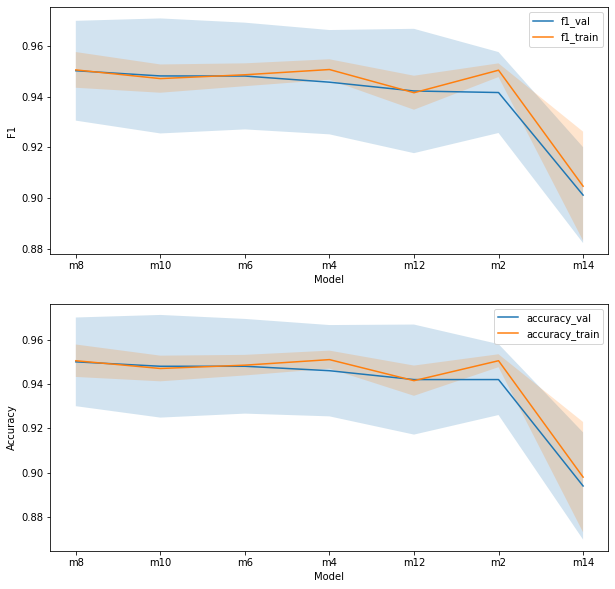

In [17]:
#@title Graficar resultados { run: "auto" }

def plot_stat_cv(param_name, param, means, stds,ax = None):
  '''
  Plots cross validation statistics (mean and std) against parameter
  '''
  if ax is None:
    ax = plt.gca()

  ax.plot(param,means, label = param_name)
  std_err = np.array(stds)
  ax.fill_between(param, np.array(means) + std_err, np.array(means) - std_err, alpha=0.2)

# Rank by descending f1 score on validation set
df_results=df_results_filt.sort_values(by='rank_test_f1', ascending=True)


# Plot results
fig, axes = plt.subplots(2,1)
fig.set_size_inches(10,10)

plot_stat_cv('f1_val','m'+df_results.index.astype(str).astype(str),df_results['mean_test_f1'],df_results['std_test_f1'],axes[0])
plot_stat_cv('f1_train','m'+df_results.index.astype(str).astype(str),df_results['mean_train_f1'],df_results['std_train_f1'],axes[0])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1')
axes[0].legend()

plot_stat_cv('accuracy_val','m'+df_results.index.astype(str).astype(str),df_results['mean_test_accuracy'],df_results['std_test_accuracy'],axes[1])
plot_stat_cv('accuracy_train','m'+df_results.index.astype(str).astype(str),df_results['mean_train_accuracy'],df_results['std_train_accuracy'],axes[1])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy')
axes[1].legend()


In [18]:
#@title Seleccionar mejor modelo { run: "auto" }

clf = gs.best_estimator_
clf

Pipeline(memory=None,
         steps=[('mms', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=20, p=2,
                                      weights='uniform'))],
         verbose=False)

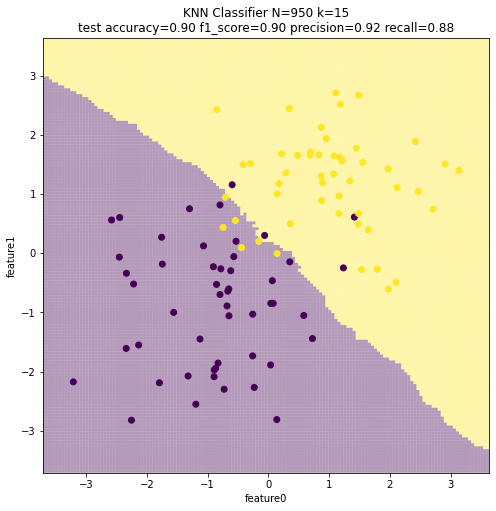

In [19]:
#@title Probar con datos no vistos (test set){ run: "auto" }

# Generate data
df_test = gen_data(N=100,dist=1,random_seed=True)

# Get X and y
X_test,y_test = prepare_data(df_test)

y_pred = clf.predict(X_test)

# Calculate metrics
metrics = calc_metrics(y_test,y_pred)
metrics = pd.DataFrame.from_dict([metrics], orient='columns')
metrics['data'] = 'test'

fig = plt.gcf()
fig.set_size_inches(8,8)
plot_clf(clf, X_test, y_test, metrics)

##Ejercicio 3.3

Este *dataset* está compuesto por canciones de 2017 con atributos de la API de Spotify. Cada canción ha sido etiquetada por alguien que usó "1", cuando le gusta la canción o "0" si no le gusta. 

Su tarea es construir un clasificador que pueda predecir las preferencias de los atributos de la canción.

Cada fila del *dataframe* representa una canción. Hay 16 columnas, 13 de las cuales son atributos de la canción, una columna para el nombre de la canción, una para el artista y una columna llamada "destino", que es la etiqueta mencionada anteriormente para la canción. Los atributos de la pista son: acústica, bailabilidad, duración, energía, instrumentalidad, clave, vivacidad, volumen, modo, habla, tempo, marca de tiempo, valencia (más información[aquí](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)).

In [20]:
#@title Leer dataset { run: "auto" }
#@markdown Se visualizan algunos datos de las columnas. 
#@markdown Se observa que hay varios features numéricos contínuos (ej: 'acousticness'), otros numéricos categóricos (ej: 'key'), y otros de texto categóricos (ej: 'artist')
#@markdown La columna Unnamed parece ser un índice, se descartará.
#@markdown La columna 'target' contiene las etiquetas de clasificación.

# Read dataset
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
df.head(10)

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
5,5,0.00479,0.804,251333,0.560,0.000000,8,0.1640,-6.682,1,0.1850,85.023,4.0,0.264,1,Sneakin’,Drake
6,6,0.01450,0.739,241400,0.472,0.000007,1,0.2070,-11.204,1,0.1560,80.030,4.0,0.308,1,Childs Play,Drake
7,7,0.02020,0.266,349667,0.348,0.664000,10,0.1600,-11.609,0,0.0371,144.154,4.0,0.393,1,Gyöngyhajú lány,Omega
8,8,0.04810,0.603,202853,0.944,0.000000,11,0.3420,-3.626,0,0.3470,130.035,4.0,0.398,1,I've Seen Footage,Death Grips
9,9,0.00208,0.836,226840,0.603,0.000000,7,0.5710,-7.792,1,0.2370,99.994,4.0,0.386,1,Digital Animal,Honey Claws


In [21]:
#@title Columnas y tipos de datos { run: "auto" }
#@markdown Se visualizan los tipos de datos de las columnas.
#@markdown No hay datos faltantes.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


In [22]:
#@title Columna label { run: "auto" }
#@markdown Se identifican los valores distintos que toma la columna, son 1 y 0.
#@markdown Se visualiza la estadística de la columna target. La media es 0.5 por lo que está equilibrado.

columns_label = 'target'

print('Target unique values: ', df[columns_label].unique(), '\n')
print('Target statistics: \n')
df[columns_label].describe()


Target unique values:  [1 0] 

Target statistics: 



count    2017.000000
mean        0.505702
std         0.500091
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [23]:
#@title Columnas numéricas { run: "auto" }
#@markdown Se visualizan las estadísticas de las columnas numércias. 
#@markdown Se observa que la escala varía entre ellas. 
#@markdown Será conveniente escalar las mismas previo al entrenamiento

columns_numeric = ['acousticness',
                   'danceability',
                   'duration_ms',
                   'energy',
                   'instrumentalness',
                   'liveness',
                   'loudness',
                   'speechiness',
                   'tempo',
                   'valence']

df[columns_numeric].describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,0.190844,-7.085624,0.092664,121.603272,0.496815
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,0.155453,3.761684,0.089931,26.685604,0.247195
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.018800,-33.097000,0.023100,47.859000,0.034800
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,0.092300,-8.394000,0.037500,100.189000,0.295000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,0.127000,-6.248000,0.054900,121.427000,0.492000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,0.247000,-4.746000,0.108000,137.849000,0.691000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,0.969000,-0.307000,0.816000,219.331000,0.992000


In [24]:
#@title Columnas categóricas tipo numerico{ run: "auto" }
#@markdown Se visualizan los valores distintos de las variables categóricas clave, modo y tiempo.

columns_categorical_num = ['key',
                           'mode',
                           'time_signature']

unique_values = {}

for column in columns_categorical_num:
  values = list(df[column].unique())
  values.sort()
  unique_values[column] = values

for column in columns_categorical_num:
  print(f'There are {len(unique_values[column])} distinct "{column}" values: ', unique_values[column], '\n')



There are 12 distinct "key" values:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 

There are 2 distinct "mode" values:  [0, 1] 

There are 4 distinct "time_signature" values:  [1.0, 3.0, 4.0, 5.0] 



In [25]:
#@title Columnas categóricas tipo string{ run: "auto" }
#@markdown Se visualizan los valores distintos de artistas y canciones. Estas no se utlizarán en este modelo.

columns_categorical_str = ['artist', 'song_title']

for column in columns_categorical_str:
  values = list(df[column].unique())
  values.sort()
  unique_values[column] = values

for column in columns_categorical_str:
  print(f'There are {len(unique_values[column])} distinct "{column}" values: ', unique_values[column][:5], '... \n')



There are 1343 distinct "artist" values:  ['!!!', '*NSYNC', '10cm', '2 Chainz', '2 LIVE CREW'] ... 

There are 1956 distinct "song_title" values:  ['$ave Dat Money (feat. Fetty Wap & Rich Homie Quan)', "'Till I Collapse", '(Bonus) Break Her Down', '(Everything I Do) I Do It For You', '(You Drive Me) Crazy'] ... 



In [26]:
#@title Preparar datos{ run: "auto" }

# Feature column names
columns_features = columns_numeric + columns_categorical_num #+ columns_categorical_str

# Shuffle dataset
df_shuffle = df.sample(frac=1)

# Leave out some data as test set
ntest = 200

# Training and validation data
X = df_shuffle[columns_features].iloc[:-ntest]
y = df_shuffle[columns_label].iloc[:-ntest]

# Test data
X_test = df_shuffle[columns_features].iloc[-ntest:]
y_test = df_shuffle[columns_label].iloc[-ntest:]


In [27]:
#@title Grid search optimization { run: "auto" }
#@markdown Se configura un pipeline donde se incluye una etapa de preprocesamiento.
#@markdown En esta etapa los features numéricos se escalan centrandolos en su media y dividiendolos por su desvío estándar.
#@markdown Los features categóricos se codifican con one-hot encoding.
#@markdown A continuación se conecta un clasificador KNN.
#@markdown Se configura un gridsearch para determinar la métrica del clasificador y el número de vecinos 'n_neighbors'
#@markdown La métrica a optimizar es el F1-score.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_selector

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
#label_transformer = CountVectorizer()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_numeric),
        ('cat', categorical_transformer, columns_categorical_num),
        #('lbl1', label_transformer, 'artist'),
        #('lbl2', label_transformer, 'song_title')
        ])

clf = Pipeline(steps=[('pre', preprocessor),
                      ('knn', KNeighborsClassifier())])
# Tunable parameters
params = [{'knn__n_neighbors': range(1,49,4),
           'knn__metric': ['euclidean', 'manhattan']
          }]

# Metrics
scoring = ['accuracy','f1']

# Grid search
gs = GridSearchCV(clf,
                   param_grid=params,
                   scoring=scoring,
                   refit='f1',
                   cv=5, 
                   return_train_score=True)

# Fit grid search
gs.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['acousticness',
                                                                          'danceabil

In [28]:
#@title Ordenar modelos segun F1 score descendente en test (val) { run: "auto" }
#@markdown Se copian los resultados a un data frame, y se ordenan por performance en la métrica F1-score.
#@markdown Se observa que algunos modelos exhiben overfitting, presentando métricas F1-score muy elevadas durante el entrenamiento, pero no así en validación.

# Convert results to dataframe for analisys
df_results = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')

# Print 5 best models 
df_stat = df_results.sort_values(by='rank_test_f1', ascending=True)[['rank_test_f1','param_knn__n_neighbors', 'param_knn__metric', 'mean_test_f1','mean_train_f1','mean_test_accuracy','mean_train_accuracy']]
df_stat

,rank_test_f1,param_knn__n_neighbors,param_knn__metric,mean_test_f1,mean_train_f1,mean_test_accuracy,mean_train_accuracy
3,1,13,euclidean,0.691515,0.733527,0.718763,0.755503
4,2,17,euclidean,0.688081,0.723671,0.719320,0.749311
14,3,9,manhattan,0.687947,0.749763,0.717657,0.770637
1,4,5,euclidean,0.683258,0.791346,0.699493,0.798981
2,5,9,euclidean,0.682922,0.757563,0.708855,0.772977
13,6,5,manhattan,0.671175,0.795827,0.696204,0.805035
0,7,1,euclidean,0.670411,0.999187,0.679128,0.999175
5,8,21,euclidean,0.667988,0.706595,0.705012,0.738029
7,9,29,euclidean,0.667703,0.690067,0.709958,0.729224
6,10,25,euclidean,0.666954,0.696162,0.707208,0.731838


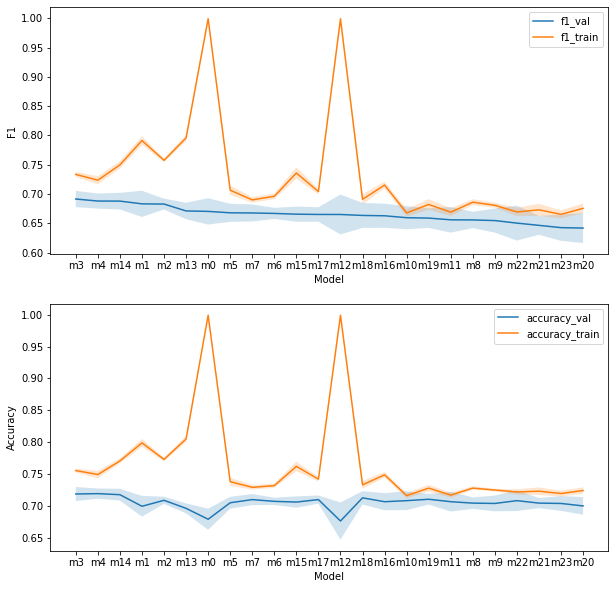

In [29]:
#@title Graficar resultados{ run: "auto" }
#@markdown Se grafican los resultados de los distintos modelos ordenados de mejor a peor.
#@markdown Los picos en las métricas de entrenamiento corresponden a los modelos con overfitting.
#@markdown Otros modelos presentan valores bajos tanto en entrenamiento como validación (underfitting).

# Plot results
fig, axes = plt.subplots(2,1)
fig.set_size_inches(10,10)

df_results= df_results.sort_values(by='rank_test_f1', ascending=True)

plot_stat_cv('f1_val','m'+df_results.index.astype(str).astype(str),df_results['mean_test_f1'],df_results['std_test_f1'],axes[0])
plot_stat_cv('f1_train','m'+df_results.index.astype(str).astype(str),df_results['mean_train_f1'],df_results['std_train_f1'],axes[0])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1')
axes[0].legend()

plot_stat_cv('accuracy_val','m'+df_results.index.astype(str).astype(str),df_results['mean_test_accuracy'],df_results['std_test_accuracy'],axes[1])
plot_stat_cv('accuracy_train','m'+df_results.index.astype(str).astype(str),df_results['mean_train_accuracy'],df_results['std_train_accuracy'],axes[1])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

In [30]:
#@title Seleccionar mejor modelo { run: "auto" }
#@markdown Se guarda el mejor resultado dado por gridsearch.

clf_best = gs.best_estimator_
clf_best

Pipeline(memory=None,
         steps=[('pre',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                            

In [31]:
#@title Probar con datos no vistos (test set){ run: "auto" }
#@markdown Se evalúan las métricas con el dataset que no se usó para entrenar ni validar. 
#@markdown Se observa una ligera degradación de las métricas, pero están en el orden de las obtenidas durante el entrenamiento.

y_pred = clf_best.predict(X_test)

# Calculate metrics
metrics = calc_metrics(y_test,y_pred)
metrics = pd.DataFrame.from_dict([metrics], orient='columns')
metrics['data'] = 'test'

metrics

,accuracy,f1_score,precision,recall,data
0,0.735,0.710383,0.764706,0.663265,test
